
# Automated Detection of Hearing Thresholds using Auditory Brainstem Response Waves

The primary goal of this notebook is to automate the process of extracting hearing thresholds from auditory brainstem response (ABR) waves. Traditionally, this has been done via visual inspection of ABR waves; researchers look at groups of ABR waves and decide that the threshold is at the minimum dB level in which an ABR wave appears to have some structure. This process is not only subjective but also time-consuming. Different researchers frequently call thresholds at different dB levels. Differences of up to 10dB are considered normal in the field. By automating this process, we aim to increase the objectivity and efficiency of hearing threshold detection.

## Approach

The approach we take is twofold:

1. **Prediction of Hearing Waves:** We first employ a machine learning classifier to predict whether individual ABR waves represent hearing. This prediction is based on the characteristics of the waves and the model's learned understanding of what constitutes a hearing wave. The reason we first classify individual ABR waves and then extract the threshold (instead of directly predicting the threshold) is because our approach allows us to use the explanatory power wave-level features.

2. **Threshold Detection:** Once we have identified the waves that represent hearing, we proceed to determine the hearing threshold. This is done by selecting the lowest decibel level at which a subject can hear. 

## Summary of Contents

1. **EDA and Data Prep-Processing**
2. **Feature Engineering**
3. **Model Fitting**
4. **Determing Thresholds from Individual Wave Classification**
5. **Conclusions**

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import fdasrsf as fs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


First, we import several Python libraries that are commonly used in data analysis and machine learning:

- `pandas`: This library is used for data manipulation and analysis. It provides data structures and functions needed to manipulate structured data.
- `os` and `glob`: These libraries are used for interacting with the operating system. This is used for loading our data.
- `matplotlib.pyplot`: This is a plotting library used for creating visualization. We use this for our exploratory data analysis.
- `numpy`: This library is used for numerical computations in Python.
- `fdasrsf`: This library is used for functional data analysis. We use it to align ABR waves for feature extraction in the pre-processing step
- `sklearn.model_selection.train_test_split`: This function is used to split datasets into training and testing sets.
- `sklearn.metrics.accuracy_score`: This function is used to calculate the accuracy score of a model.
- `xgboost.XGBClassifier`: The XGBClassifier is used for classifying our ABR waves
- `sklearn.model_selection.cross_val_score`: This function is used to evaluate a score by cross-validation.
- `sklearn.model_selection.RandomizedSearchCV`: This function is used for hyperparameter tuning. 

# 1. EDA and Data Pre-Processing

In [2]:
# Load ABR data
directory = '/Users/jeffreychen/Desktop/SALK/ucsdpracticum/ABR_exported_files'
all_files = glob.glob(os.path.join(directory, '*.csv'))
filtered_files = [file for file in all_files if 'click' not in file.lower()]
dfs = []

for filename in filtered_files:
    temp_df = pd.read_csv(filename)  
    temp_df['filename'] = os.path.basename(filename)
    dfs.append(temp_df)
df = pd.concat(dfs, ignore_index=True)

df = df.dropna(axis=1, how='all')
df = df.iloc[:,0:247]
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]


In [3]:
# Add 'Hearing' label to ABR data
thresholds = pd.read_csv('/Users/jeffreychen/Desktop/SALK/ucsdpracticum/Clustering Pipelines/thresholds.csv')
thresholds_long = thresholds.melt(id_vars='Freq(Hz)', var_name='filename', value_name='Level(dB)')
thresholds_long = thresholds_long[thresholds_long['Freq(Hz)'] != 'click']
thresholds_long['Freq(Hz)'] = thresholds_long['Freq(Hz)'].astype(float)
merged_df = pd.merge(df, thresholds_long, on=['filename', 'Freq(Hz)'], suffixes=('_df', '_thresholds'))
merged_df['Hearing'] = (merged_df['Level(dB)_thresholds'] <= merged_df['Level(dB)_df']).astype(int)
df = merged_df.drop(columns=['Level(dB)_thresholds'])
df = df.rename(columns={'Level(dB)_df': 'Level(dB)'})
cols = df.columns.tolist()
cols.remove('Hearing')
cols.insert(1, 'Hearing')
df = df[cols]


## Data Description

In [7]:
df

,filename,Hearing,Freq(Hz),Level(dB),0,1,2,3,4,5,...,234,235,236,237,238,239,240,241,242,243
0,C1_1466_tone baseline.csv,1,4000.0,90.0,-0.000597,-0.000286,-0.000316,-0.000600,-0.000917,-0.000917,...,-0.007261,-0.007451,-0.007606,-0.007511,-0.006891,-0.005645,-0.004153,-0.002892,-0.002030,-0.001380
1,C1_1466_tone baseline.csv,1,4000.0,85.0,0.002433,0.001911,0.000931,-0.000344,-0.001475,-0.002030,...,-0.004121,-0.002632,-0.001150,0.000062,0.000785,0.000957,0.000798,0.000304,-0.000682,-0.001996
2,C1_1466_tone baseline.csv,1,4000.0,80.0,-0.001345,-0.001635,-0.001974,-0.002228,-0.002431,-0.002638,...,-0.009027,-0.009711,-0.009966,-0.009701,-0.009085,-0.008476,-0.008183,-0.008270,-0.008426,-0.008304
3,C1_1466_tone baseline.csv,1,4000.0,75.0,-0.001062,-0.001471,-0.002069,-0.002583,-0.002883,-0.003029,...,0.003454,0.003308,0.002909,0.002426,0.001794,0.001070,0.000507,0.000276,0.000372,0.000562
4,C1_1466_tone baseline.csv,0,4000.0,70.0,0.001651,0.002615,0.003408,0.003779,0.003936,0.004128,...,0.004428,0.005059,0.005510,0.005989,0.006726,0.007399,0.007460,0.006635,0.005306,0.004265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6756,B2_1289_tone 24h.csv,0,32000.0,40.0,0.001439,0.001768,0.001864,0.001781,0.001276,0.000279,...,-0.002374,-0.001902,-0.001535,-0.001602,-0.002040,-0.002448,-0.002535,-0.002192,-0.001661,-0.001362
6757,B2_1289_tone 24h.csv,0,32000.0,35.0,0.002664,0.001502,0.000357,-0.000339,-0.000521,-0.000356,...,0.002736,0.003481,0.004151,0.004467,0.004153,0.003395,0.002527,0.001671,0.000753,-0.000268
6758,B2_1289_tone 24h.csv,0,32000.0,30.0,-0.001603,-0.001321,-0.000763,-0.000379,-0.000641,-0.001591,...,-0.005427,-0.004721,-0.004300,-0.004493,-0.004927,-0.005265,-0.005358,-0.005070,-0.004541,-0.004072
6759,B2_1289_tone 24h.csv,0,32000.0,25.0,0.000910,0.000437,-0.000178,-0.000800,-0.001349,-0.001662,...,0.001598,0.002101,0.002218,0.001600,0.000361,-0.001055,-0.002238,-0.002847,-0.002832,-0.002456


Our data is sourced from labelled ABR recordings on mice conducted by researchers at UCSD and Salk Institute. We have organized the data in a pandas dataframe composed of several columns, each representing different aspects of an auditory brainstem response (ABR) wave.

1. `filename`: This column contains the names of the files associated with each data entry. Each unique filename represents a different subject on which data was collected.

2. `Hearing`: This column contains human labels from Salk Institute researchers for whether an ABR wave represents hearing.

3. `Freq(Hz)`: This column represents the frequency of the ABR wave in Hertz. Each subject was played sounds at different frequencies.

4. `Level(dB)`: This column indicates the level of the ABR wave in decibels. The sounds were played at different levels for each subject.

5. `0` to `243`: These 244 columns represent the amplitudes of the ABR wave. These amplitudes are uniformly sampled over a 10ms period. Each column corresponds to a specific point in time, with `0` being the amplitude at the start of the 10ms period and `243` being the amplitude at the end.

## Checking for Class Imbalance

In [498]:
# check for class imbalance
counts = df['Hearing'].value_counts()
print(counts)

Hearing
1    808
0    506
Name: count, dtype: int64


Given that we are dealing with a classification problem, it's crucial to examine the balance of our classes. This will guide us in selecting an appropriate metric for model evaluation. 

From the output of the previous cell, we observe a relatively balanced distribution between the classes - hearing ABR waves and non-hearing ABR waves. This balance in our target variable allows us to use accuracy as a suitable metric for this problem. 


## Data Visualization

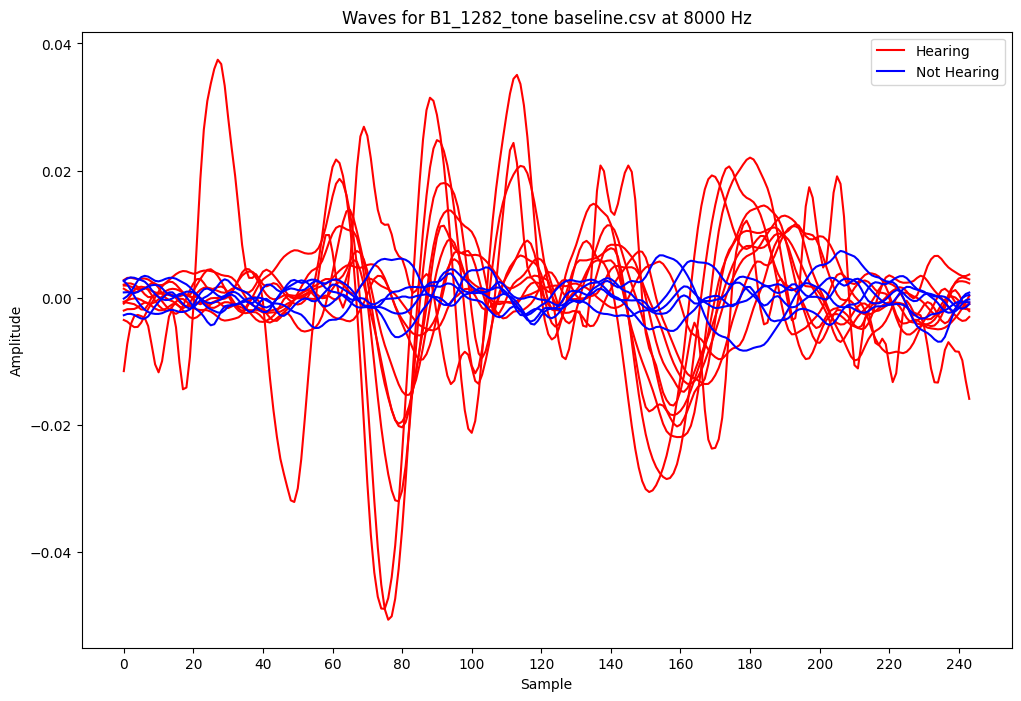

In [9]:
filename = 'B1_1282_tone baseline.csv'
frequency = 8000
df_filtered = df[(df['filename'] == filename) & (df['Freq(Hz)'] == frequency)]
fig, ax = plt.subplots(figsize=(12, 8)) 
colors = {0: 'blue', 1: 'red'}
labels = {0: 'Not Hearing', 1: 'Hearing'}

for index, row in df_filtered.iterrows():
    amplitude_data = row[4:] 
    ax.plot(amplitude_data, color=colors[row['Hearing']], label=labels[row['Hearing']])

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title(f'Waves for {filename} at {frequency} Hz')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xticks(np.arange(0, len(df.columns) - 4, 20)) 

plt.show()

Above, we've plotted ABR waves for a specific subject, captured at a fixed frequency, across all decibel levels. 

The ABR waves are color-coded to distinguish between the hearing and non-hearing states of the subject. The 'hearing' curves are depicted in red, while the 'non-hearing' curves are shown in blue.

This plot reveals some key characteristics of the ABR waves:

- **Amplitude Variations:** The absolute amplitudes of the 'hearing' curves are significantly greater at certain points. This observation aligns with our domain knowledge that a subject who hears something will typically exhibit five peaks in their ABR curves.

- **Non-Uniform Latency:** We observe a non-uniform latency across the hearing curves. This indicates that the curves are not merely shifted horizontally (time-delayed), but also exhibit variations in their shape. They appear to be stretched or compressed at different regions.


## Data Pre-Processing

Distinct **amplitude variations** between hearing and non-hearing curves suggest potential for predicting hearing ability. However, **non-uniform latency** complicates direct use of amplitudes as features. To align the curves, we'll employ **Dynamic Time Warping (DTW)**, adjusting for latency and enhancing the predictive utility of our data.

In [19]:
warped_df = df.copy()
# Create new columns filled with NaNs to store warping functions
for i in range(244, 488):
    warped_df[str(i)] = np.nan
grouped = df.groupby(['filename', 'Freq(Hz)'])

for name, group in grouped:
    if group.shape[0] < 4:  
        continue
    wave_points = group.loc[:, '0':'243'].values
    time = np.linspace(0, 1, wave_points.shape[1])
    fda_obj = fs.fdawarp(wave_points.T, time)
    fda_obj.srsf_align(parallel=True)
    warped_df.loc[group.index, '0':'243'] = fda_obj.fn.T
    warped_df.loc[group.index, '244':'487'] = fda_obj.gam.T

Initializing...


/var/folders/g_/b1twxg5159dc5n5_hm9nxdgm0000gn/T/ipykernel_63069/3110756991.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  warped_df[str(i)] = np.nan
/var/folders/g_/b1twxg5159dc5n5_hm9nxdgm0000gn/T/ipykernel_63069/3110756991.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  warped_df[str(i)] = np.nan
/var/folders/g_/b1twxg5159dc5n5_hm9nxdgm0000gn/T/ipykernel_63069/3110756991.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

Compute Karcher Mean of 8 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 10 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
I

/opt/homebrew/anaconda3/lib/python3.11/site-packages/fdasrsf/utility_functions.py:168: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparam(ascontiguousarray(q1), time,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/fdasrsf/utility_functions.py:168: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparam(ascontiguousarray(q1), time,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/fdasrsf/utility_functions.py:168: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparam(ascontiguousarray(q1), time,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/fdasrsf/utility_functions.py:168: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparam(ascontiguousarray(q1), time,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/fdasrsf/utility_functions.py:168: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparam(ascontiguousarray(q1), time,
/opt/homeb

updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 15 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 15 function in SRSF space with lam=0
upd

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 15 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 15 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
upda

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 15 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached
Initializing...
Compute Karcher Mean of 15 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
upd

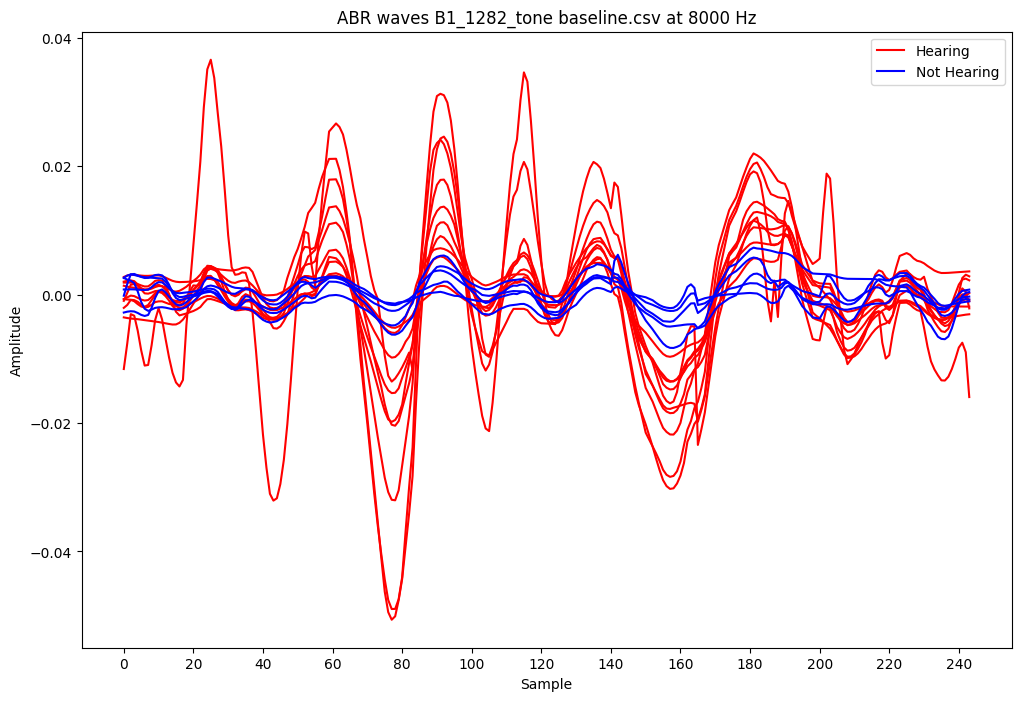

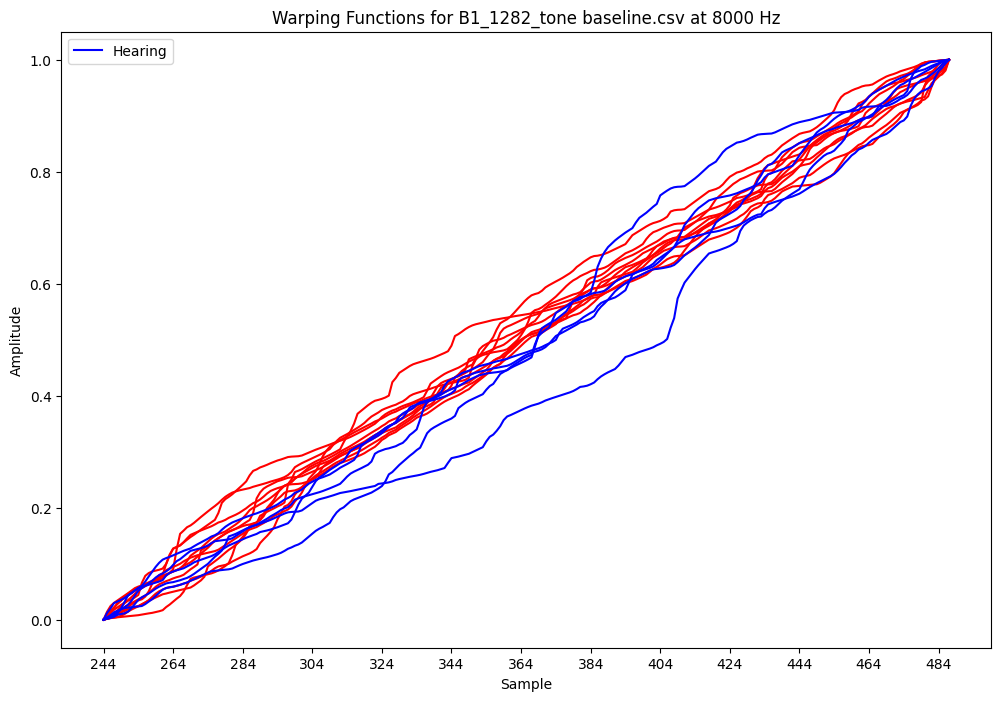

In [20]:
filename = 'B1_1282_tone baseline.csv'
frequency = 8000
df_filtered = warped_df[(warped_df['filename'] == filename) & (warped_df['Freq(Hz)'] == frequency)]
colors = {0: 'blue', 1: 'red'}
labels = {0: 'Not Hearing', 1: 'Hearing'}

# First 244 points
fig1, ax1 = plt.subplots(figsize=(12, 8)) 
for index, row in df_filtered.iterrows():
    amplitude_data = row[4:248]  # Slice the data to the first 244 points
    ax1.plot(amplitude_data, color=colors[row['Hearing']], label=labels[row['Hearing']])
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title(f'Warped ABR waves {filename} at {frequency} Hz')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xticks(np.arange(0, 244, 20)) 
plt.show()

# Next 244 points
fig2, ax2 = plt.subplots(figsize=(12, 8)) 
for index, row in df_filtered.iterrows():
    amplitude_data = row[248:492]  # Slice the data to the next 244 points
    ax2.plot(amplitude_data, color=colors[row['Hearing']], label=labels[row['Hearing']])
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title(f'Warping Functions for {filename} at {frequency} Hz')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xticks(np.arange(0, 244, 20)) 
plt.show()

By employing Dynamic Time Warping (DTW) for wave alignment, we enhance the visual distinction between threshold and non-threshold curves. More importantly, this method aligns significant features such as peak and trough amplitudes across time, enabling us to incorporate their coordinates into our machine learning algorithm.

Moreover, we can leverage the features derived from our warping functions to bolster our model. This is based on the anticipation that threshold curves, characterized by a distinct 5-peak structure, would undergo a different warping process compared to non-threshold curves. Thus, the warping features could potentially provide additional predictive power to our model.

# 2. Feature Engineering

During our exploratory data analysis, we discovered a potential relationship between the degree of warping applied to an Auditory Brainstem Response (ABR) wave and its ability to represent hearing. To further investigate this relationship, we quantify the degree of warping by creating a feature for the length of warping functions.

In [487]:
warping_columns = [str(i) for i in range(244, 488)]

def calculate_euclidean_distance(row):
    points = row[warping_columns].values 
    return np.sum(np.sqrt(np.diff(points.astype(float))**2 + 1))

warped_df['Warping_Euclidean_Distance'] = warped_df.apply(calculate_euclidean_distance, axis=1)
warping_euclidean = warped_df['Warping_Euclidean_Distance']
warped_df = warped_df.drop(columns=['Warping_Euclidean_Distance'])
warped_df.insert(4, 'Warping_Euclidean_Distance', warping_euclidean)
cols_to_drop = [str(i) for i in range(244, 488)]
warp_dist_df = warped_df.drop(columns=cols_to_drop)
warp_dist_df = warp_dist_df.groupby(['filename', 'Freq(Hz)']).filter(lambda x: len(x) >= 5) # Remove observations where there are insufficient dB levels

warp_dist_df.head(3)

/var/folders/g_/b1twxg5159dc5n5_hm9nxdgm0000gn/T/ipykernel_63069/1683236940.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  warped_df.insert(4, 'Warping_Euclidean_Distance', warping_euclidean)


,filename,Hearing,Freq(Hz),Level(dB),Warping_Euclidean_Distance,0,1,2,3,4,...,234,235,236,237,238,239,240,241,242,243
0,C1_1466_tone baseline.csv,1,4000.0,90.0,243.002520,-0.000597,-0.000296,-0.000431,-0.000556,-0.000667,...,-0.007397,-0.007255,-0.007484,-0.006697,-0.003869,-0.002020,-0.001783,-0.001615,-0.001495,-0.001380
1,C1_1466_tone baseline.csv,1,4000.0,85.0,243.002467,0.002433,0.002257,0.002013,0.001388,0.000411,...,-0.001071,-0.000793,-0.000433,-0.000117,0.000398,0.000848,0.000864,0.000359,-0.000780,-0.001996
2,C1_1466_tone baseline.csv,1,4000.0,80.0,243.003032,-0.001345,-0.001442,-0.001578,-0.001951,-0.002453,...,-0.008460,-0.008402,-0.008328,-0.008262,-0.008196,-0.008229,-0.008292,-0.008413,-0.008368,-0.008304


We compute the lengths of warping functions using the Euclidean distance, assuming that the x-axis, representing time, and the y-axis, representing the warping function, are on equivalent scales. We are able to make this assumption because each wave spans the same amount of time. Consequently, the relative ordering of lengths is maintained.

# 3. Fitting a Model (Gradient Boosted Tree - XGBoost)

We now have a dataframe where each row represents a unique ABR wave. The columns include the filename, frequency, level, hearing label, length of the warping function, and the amplitudes of the time-warped wave.

To predict hearing based on this data, we will first partition the dataset into a training set and a test set. The data is partitioned in such a way that each unique filename/frequency pairing is exclusively assigned to either the training or testing set, ensuring no overlap. This allows us to aggregate the results, predict a threshold, and subsequently compute metrics for these thresholds.

Following this, we will employ a Gradient Boosted Tree model, specifically using the XGBoost algorithm. The model’s performance will be validated and hyper-parameters will be tuned using cross-validation techniques.

In [486]:
warp_dist_df['file_freq'] = warp_dist_df['filename'].astype(str) + warp_dist_df['Freq(Hz)'].astype(str)
unique_file_freq = warp_dist_df['file_freq'].unique()
train_file_freq, test_file_freq = train_test_split(unique_file_freq, test_size=0.2, random_state=42)
train = warp_dist_df[warp_dist_df['file_freq'].isin(train_file_freq)]
test = warp_dist_df[warp_dist_df['file_freq'].isin(test_file_freq)]
X_train = train.drop(columns=['Hearing', 'filename', 'file_freq'])
y_train = train['Hearing']
X_test = test.drop(columns=['Hearing', 'filename', 'file_freq'])
y_test = test['Hearing']

model = XGBClassifier()
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]
}
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, verbose=3)
random_search.fit(X_train, y_train)
print("Best Parameters: ", random_search.best_params_)
print("Best Score: %.2f%%" % (random_search.best_score_ * 100.0))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV 4/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.846 total time=   4.2s
[CV 5/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.886 total time=   4.3s
[CV 3/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.907 total time=   4.3s
[CV 2/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.870 total time=   4.5s
[CV 1/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.917 total time=   4.7s
[CV 2/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=200;, score=0.868 total time=  24.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=200;, score=0.911 total time=  24.3s
[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.2, max_depth=8, n_estimators=200;, score=0

In [495]:
y_pred_test = random_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

test_data_with_predictions = test.copy()
test_data_with_predictions.insert(1, 'prediction', y_pred_test)
test_data_with_predictions = test_data_with_predictions[['filename','prediction', 'Hearing', 'Freq(Hz)', 'Level(dB)']]
test_data_with_predictions

Test Accuracy: 97.49%


,filename,prediction,Hearing,Freq(Hz),Level(dB)
0,C1_1466_tone baseline.csv,1,1,4000.0,90.0
1,C1_1466_tone baseline.csv,1,1,4000.0,85.0
2,C1_1466_tone baseline.csv,1,1,4000.0,80.0
3,C1_1466_tone baseline.csv,1,1,4000.0,75.0
4,C1_1466_tone baseline.csv,0,0,4000.0,70.0
...,...,...,...,...,...
6756,B2_1289_tone 24h.csv,0,0,32000.0,40.0
6757,B2_1289_tone 24h.csv,0,0,32000.0,35.0
6758,B2_1289_tone 24h.csv,0,0,32000.0,30.0
6759,B2_1289_tone 24h.csv,0,0,32000.0,25.0


With our classifier, we predict whether ABR waves in the testing set correspond to hearing and organize it in a dataframe. We also compute the accuracy of this classifier.

In [513]:
import pickle
filename = 'thresholding_model.pkl'
pickle.dump(random_search, open(filename, 'wb'))

We save our model for future use

## Feature Importance

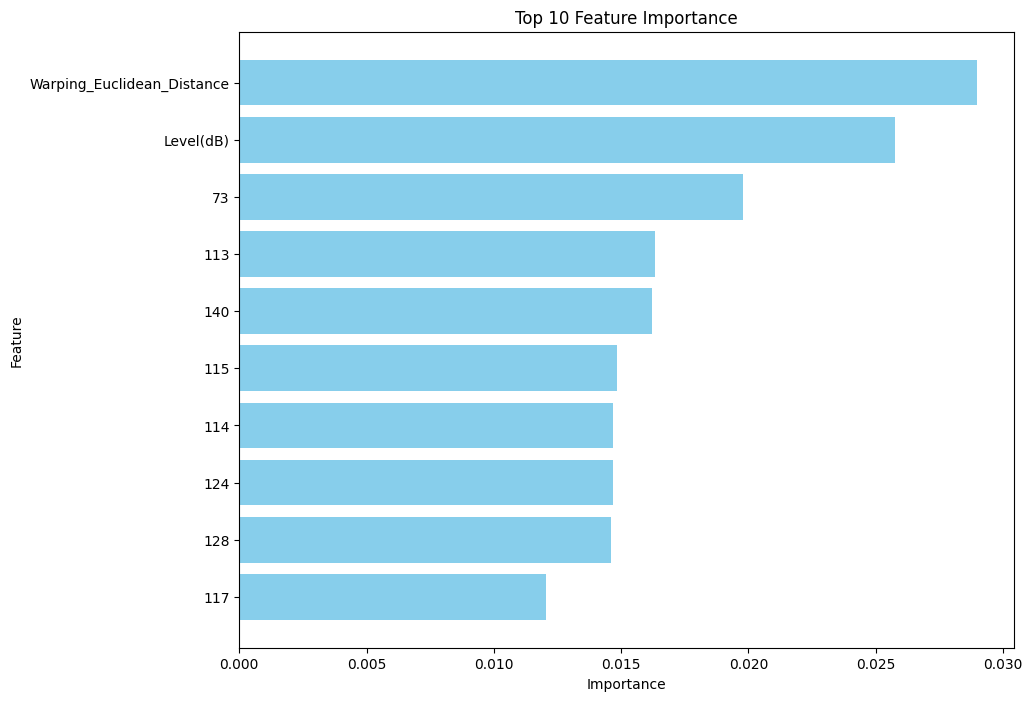

In [514]:
import matplotlib.pyplot as plt

# Get feature importances
importances = random_search.best_estimator_.feature_importances_

# Get the feature names
features = X_train.columns
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df = importance_df.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

We also showcase the significance of the top 10 features. The feature with the highest importance was the length of the warping function, followed by the dB level. Interestingly, the next eight features of high importance were predominantly associated with the amplitude of waves at typical peak and trough locations. Contrary to expectations, 'frequency' did not make it to the list of the top 10 most important features.

# 4. Determining Thresholds from Individual Wave Classifications

In [496]:
df = test_data_with_predictions
thresholds = []
for (filename, freq), group in df.groupby(['filename', 'Freq(Hz)']):
    group = group.sort_values('Level(dB)', ascending=False)
    predicted_threshold = None
    ground_truth_threshold = group[group['Hearing'] == 1]['Level(dB)'].min()
    if group['prediction'].all():
        predicted_threshold = group['Level(dB)'].min()
    else:
        for i in range(1, len(group)):
            if group.iloc[i-1]['prediction'] == 1 and group.iloc[i]['prediction'] == 0:
                if predicted_threshold is None:
                    predicted_threshold = group.iloc[i]['Level(dB)']
            elif group.iloc[i-1]['prediction'] == 0 and group.iloc[i]['prediction'] == 1:
                predicted_threshold = group.iloc[i-1]['Level(dB)']
    thresholds.append(pd.DataFrame({'filename': [filename], 'Freq(Hz)': [freq], 'predicted_threshold': [predicted_threshold], 'ground_truth_threshold': [ground_truth_threshold]}))
thresholds = pd.concat(thresholds, ignore_index=True)
thresholds = thresholds[['filename', 'Freq(Hz)', 'predicted_threshold', 'ground_truth_threshold']]

In [497]:
# Calculate the absolute difference between predicted and ground truth thresholds
thresholds['diff'] = np.abs(thresholds['predicted_threshold'] - thresholds['ground_truth_threshold'])

# Calculate the percentages
within_5db_percentage = (thresholds['diff'] <= 5).mean() * 100
within_10db_percentage = (thresholds['diff'] <= 10).mean() * 100
within_15db_percentage = (thresholds['diff'] <= 15).mean() * 100

print(f'Within 5 db: {within_5db_percentage}%')
print(f'Within 10 db: {within_10db_percentage}%')
print(f'Within 15 db: {within_15db_percentage}%')

Within 5 db: 87.5%
Within 10 db: 93.26923076923077%
Within 15 db: 96.15384615384616%


Finally, we use the classification of individual ABR waves to make threshold predictions. The predicted threshold is defined as the lowest dB level that was classified as hearing. We quantify the performance of our predictions by computing the percentage of predicted thresholds that are within 10 dB of their labels, a common metric used in Otoryngology.

# 5. Conclusions

Our approach utilizes the classification of individual Auditory Brainstem Response (ABR) waves to predict hearing thresholds. The predicted threshold is identified as the lowest decibel (dB) level at which an individual wave is classified as audible. We evaluate the accuracy of our predictions by calculating the proportion of predicted thresholds that fall within a 10 dB range of their actual values, a standard measure in Otoryngology. Our method achieves an out-of-sample within-10dB accuracy rate of approximately 93.27%, matching the performance of existing algorithms in the field. The key advantage of our approach is its simplicity: it does not require ABR wave traces, but instead directly uses the ABR waves. As a result, we have achieved comparable performance to existing models while utilizing significantly less data.